In [11]:
!pip install opencv-contrib-python
!pip install opencv-python
!pip install opencv-python-headless==4.1.2.30

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np 

## 图像梯度

In [16]:
def filter_image_with_kernel(img: np.array, kernel: np.array) -> np.array:
    """对图像进行卷积运算

    使用参数提供的kernel，对图像进行卷积运算，返回卷积计算结果。我们暂不考虑步长的问题，后面课程到卷积部分会单独实现。

    Args:
        img: 单通道图像，格式为np.array
        kernel: np.array二维数组，这里我们简化问题，先限定kernel的宽和高相等并且为奇数
    
    Return:
        返回卷积运算后的图像

    Raises:
        ValueError: 当传入的数据格式不符合要求时，抛出ValueError异常
    """

    if len(img.shape) != 2:
        #TODO(NighWalker888): 处理多通道输入
        raise ValueError

    if len(kernel.shape) != 2:
        raise ValueError

    h, w = img.shape[:2]
    kernel_h, kernel_w = kernel.shape[:2]

    if kernel_h != kernel_w or kernel_w % 2 == 0:
        #TODO(NighWalker888): 处理不同宽高的kernel，处理宽高存在偶数的情况
        raise ValueError

    filtered_img = np.zeros_like(img)
    # 我们使用0值对图像进行补全(padding)，保证图像卷积运算后尺寸不变
    padding_img = np.zeros((kernel_h - 1 + h, kernel_w - 1 + w))
    padding_img[int(kernel_h / 2 - 1):int(kernel_h / 2 - 1) + h, 
                int(kernel_w / 2 - 1):int(kernel_w / 2 - 1) + w] = img 

    conv = lambda region,kernel: np.sum(region.flatten() * kernel.flatten())  
    
    for row in range(h):
        for col in range(w):
            target_region = padding_img[row:row + kernel_h, col:col + kernel_w]
            filtered_img[row, col] = conv(target_region, kernel)
    
    return filtered_img

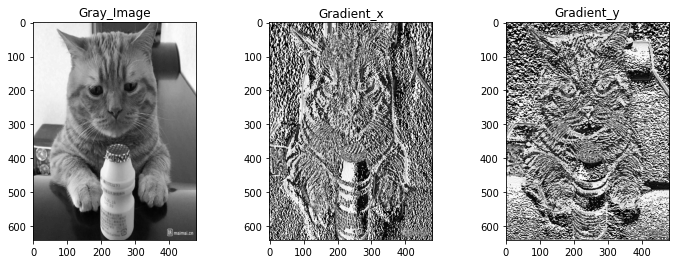

In [20]:
img_gray = cv2.imread("../demo_images/little_cat.jpg", cv2.IMREAD_GRAYSCALE) 

prewitt_kernel_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
prewitt_kernel_y = prewitt_kernel_x.T #矩阵转置

img_grad_x = filter_image_with_kernel(img_gray, prewitt_kernel_x)
img_grad_y = filter_image_with_kernel(img_gray, prewitt_kernel_y)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title("Gray_Image")
plt.imshow(img_gray,cmap = 'gray')

plt.subplot(1,3,2)
plt.title("Gradient_x")
plt.imshow(img_grad_x,cmap = 'gray')

plt.subplot(1,3,3)
plt.title("Gradient_y")
plt.imshow(img_grad_y,cmap = 'gray')

plt.show()
# plt.savefig("../course_images/gradient.jpg", dpi = 300)


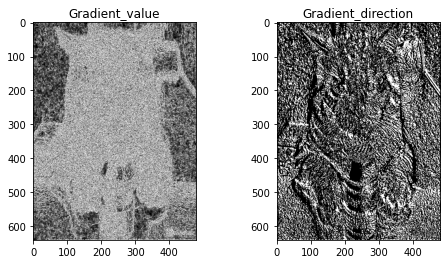

In [29]:
img_grad_value = np.sqrt(img_grad_x ** 2 + img_grad_y ** 2)
img_grad_direct = np.arctan2(img_grad_y, img_grad_x)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title("Gradient_value")
plt.imshow(img_grad_value.astype(np.uint8),cmap = 'gray')

plt.subplot(1,2,2)
plt.title("Gradient_direction")
plt.imshow(img_grad_direct.astype(np.uint8),cmap = 'gray')

plt.show()
# plt.savefig("../course_images/gradient_attr.jpg", dpi = 300)


## SIFT算子

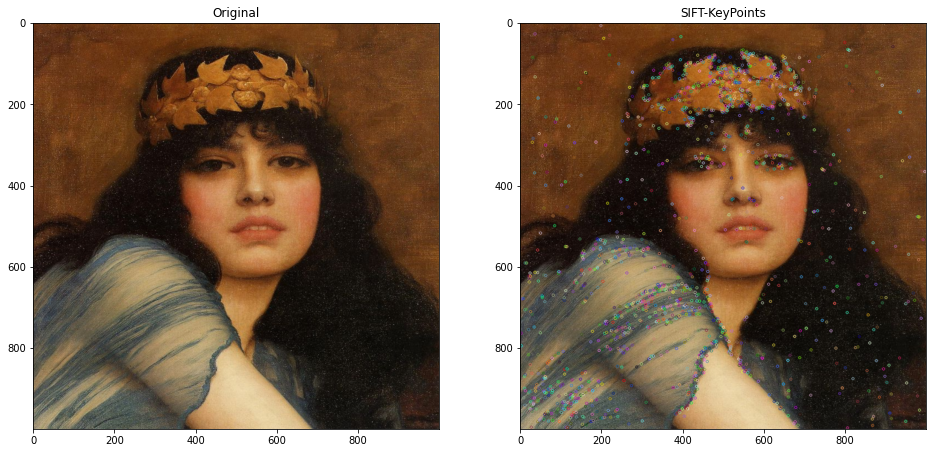

In [47]:
img_bgr = cv2.imread("../demo_images/paint.jpg", cv2.IMREAD_COLOR)
sift = cv2.SIFT_create()
key_point = sift.detect(img_bgr, None)
"""
OpenCV的KeyPoint类型的数据结构依次包含:
    angle: 角度。表示关键点的梯度方向，初值为 -1。
    class_id:分类标签。当需要对图像进行分类时，可以人为设定，初值为 -1。
    octave: 关键点的尺度定位。代表是从DOG金字塔中的哪一层提取的得到的数据。
    pt: 关键点的坐标。
    response: 该关键点的角点程度。
    size: 该关键点的直径大小。
"""
img_bgr_sift=cv2.drawKeypoints(img_bgr, key_point, None)
key_point, des = sift.compute(img_bgr, key_point) #入参的key_point和返回的key_point数值相同
plt.figure(figsize=(16,10))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(img_bgr[:,:,::-1]) #[:,:,::-1]通过的numpy的通道翻转，实现BGR转RGB
#plt.show()
plt.subplot(1,2,2)
plt.title("SIFT-KeyPoints")
plt.imshow(img_bgr_sift[:,:,::-1])
plt.show()
# plt.savefig("../course_images/sift.jpg", dpi = 300)

In [48]:
# for item in ['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'angle', 'class_id', 'convert', 'octave', 'overlap', 'pt', 'response', 'size']:
#     print(getattr(key_point[0], item) == getattr(key_point2[0], item))

print(des.shape, len(key_point))

(1802, 128) 1802
